# Determining a Person's Age from Images using Computer Vision with ResNet50 and TensorFlow

<a id='intro'></a>


The data used in this project is sourced from Kaggle, specifically the APPA-REAL Face dataset (https://www.kaggle.com/datasets/abhikjha/appa-real-face-cropped/data). This project leverages Data Science and computer vision to estimate the age of customers based on a collection of photos taken at a supermarket's checkout area. To achieve this, a model will be created and trained using Convolutional Neural Networks (CNN), specifically ResNet50 with pre-trained parameters from ImageNet. The model's evaluation metrics include loss (MSE) and scoring (MAE), with a target MAE-validation below 8. This indicates that when the model predicts a photo, it will likely have an error margin within 8 years above or below the actual age, which is crucial for developing a high-quality model.

# 1. Data Preparation

# 1.1 Initialitation

Several modules, such as pandas, matplotlib, and seaborn, will be used for data processing and visualization. The convolutional neural network (CNN) will be implemented using modules from deep learning - keras, specifically ResNet50, along with other supporting tools as follows:

In [ ]:
#Importing Modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# 1.2 Loading Data

Two types of data are available: image files and image labels. The image files consist of a collection of images/photos stored in a single folder, with each photo accompanied by its own file name. The image labels are tabular data in .csv format containing two columns: file_name and the label, which is the age of the person in the image/photo. For more details:

    The final_files folder contains 7.6 thousand photos.
    The labels.csv file contains the labels, with two columns: file_name and real_age.

Given the large number of photos, they will be read separately or not all at once using ImageDataGenerator to conserve computational resources.

In [ ]:
face_path = r'C:\Users\afifa\ProjectDatascience\final_files'
label_path = r'C:\Users\afifa\ProjectDatascience\labels.csv'

The training data will be divided into several batches, with each batch containing 32 photos, and the resolution of the photos will be adjusted to [224 x 224].

In [ ]:
# Loading Dataset Label
labels = pd.read_csv(label_path)

# Loading Data Train using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=face_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


It can be observed that there are 7591 photos in the dataset. Next, the label dataset will be checked.

In [ ]:
# Checking Label Dataset Information
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
# Showing Sample Dataset Lable
labels.sample(5)

,file_name,real_age
4892,004892.jpg,4
6238,006242.jpg,27
2782,002782.jpg,31
4573,004573.jpg,32
4775,004775.jpg,72


The data has the same number of entries as the training data, with 7591 rows and two columns, and no missing values. Next, the presence of any duplicate data will be checked.

In [ ]:
# Checking Duplicate Data
labels.duplicated().sum()

0

It has been found that there are no duplicate entries in the label dataset.

# 1.3 Data Separation

Since the training data has been divided into smaller batches using ImageDataGenerator, it will be adjusted by separating the data into feature and target/label datasets as follows. The shape of each dataset will be verified to ensure they are correct.

In [ ]:
# Feature and Lable Separation
feature, label = next(train_gen_flow)

In [ ]:
# Feature Shape
feature.shape

(32, 224, 224, 3)

From batch-1, 32 photos with a resolution of [224 x 224] and 3 channels are obtained.

In [ ]:
#Lable Shape
label.shape

(32,)

From `batch-1`, 1 column containing 32 rows of labels is obtained. Both datasets are in accordance, and the analysis will now proceed using EDA (Exploratory Data Analysis).

# Tahap 2. Explorative Data Analysis (EDA)

Next, Exploratory Data Analysis (EDA) will be conducted to examine the age distribution in the dataset and to match the images/photos with the age labels.

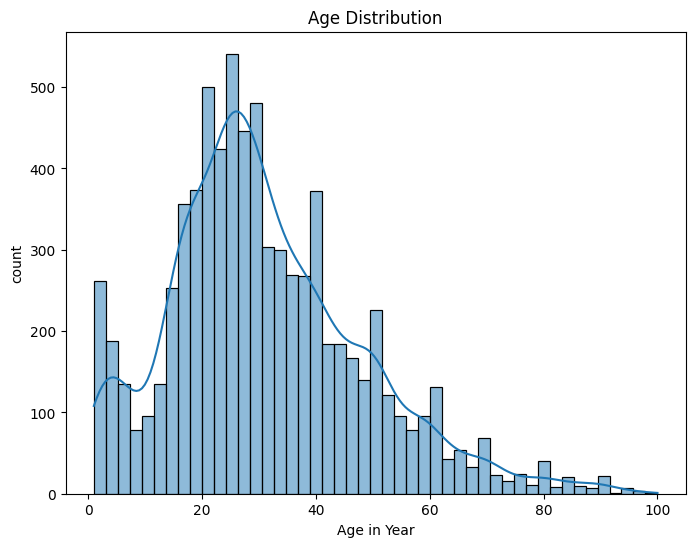

In [ ]:
#Age Distribution Visualization
plt.figure(figsize=(8,6))
sns.histplot(data=labels, x="real_age", kde=True)
plt.title('Age Distribution')
plt.xlabel('Age in Year')
plt.ylabel('count')
plt.show()

From this, it can be observed that the age range is from 1 to 100 years, with the majority of ages falling between 20 and 40 years.

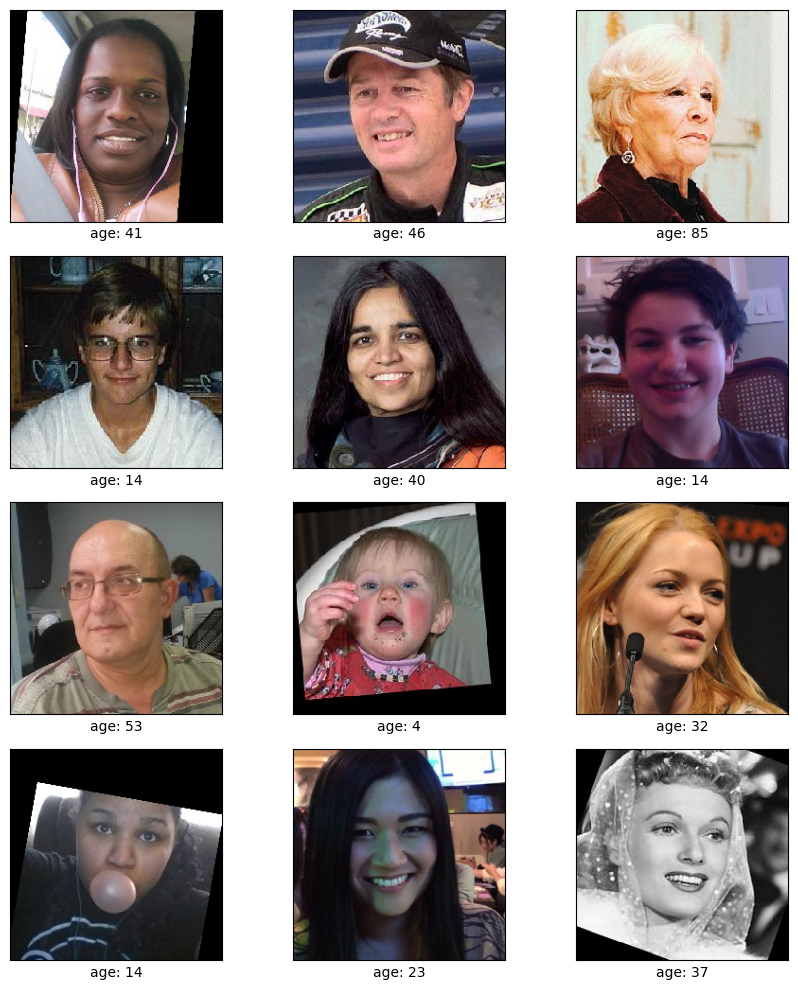

In [ ]:
#Matching images/photos with age labels

#Index
idx = [1,2,3,4,5,6,7,8,9,10,11,12]

#Image and Age Ploting
fig = plt.figure(figsize=(10,10))
for i,val in enumerate(idx):
    ax = fig.add_subplot(4, 3, i+1)
    plt.imshow(feature[val])
    ax.set_xlabel(f'age: {label[val]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Based on the Exploratory Data Analysis (EDA), it was found that the age range in the dataset spans from 1 to 100 years, with the majority falling between 20 and 40 years. The sample feature check showed that the images and labels are aligned with expectations. The next steps can now be proceeded with.

# 3. Training CNN Model

Functions need to be created to train the CNN model, including functions for loading each dataset (training and test), defining the CNN model, and training the CNN model.

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#A function will be created for loading the train dataset.
def load_train(path):
    """
    The code loads the training set from the file path.
    """#The paths for the training data and training labels are loaded.
    face_path = path + 'final_files/'
    label_path = path + 'labels.csv'#The training label dataset is loaded.
    labels = pd.read_csv(label_path)

    #The training data is loaded using ImageDataGenerator.
    train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.25)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=face_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

#Data Train Loading
train_gen_flow = load_train('C:\\Users\\afifa\\ProjectDatascience\\')


# Check if train_gen_flow is not None and print some details
if train_gen_flow:
    print(f"Batch size: {train_gen_flow.batch_size}")
    print(f"Number of samples: {train_gen_flow.samples}")
    # Try getting a batch of images and labels
    batch = next(train_gen_flow)
    print(f"Batch image shape: {batch[0].shape}")
    print(f"Batch label shape: {batch[1].shape}")
else:
    print("Failed to create the data generator.")

#A function will be created for loading the test dataset.
def load_test(path):
    """
    The code loads the validation/test set from the file path.
    """#The paths for the test data and test labels are loaded.
    face_path = path + 'final_files/'
    label_path = path + 'labels.csv'#The test label dataset is loaded.
    labels = pd.read_csv(label_path)

    #The test data is loaded using ImageDataGenerator.
    test_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=face_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',  # Specify validation subset
        seed=12345)

    return test_gen_flow

#Data Test Loading
test_gen_flow = load_test('C:\\Users\\afifa\\ProjectDatascience\\')

# Check if test_gen_flow is not None and print some details
if test_gen_flow:
    print(f"Batch size: {test_gen_flow.batch_size}")
    print(f"Number of samples: {test_gen_flow.samples}")
    print(f"Image shape: {test_gen_flow.image_shape}")
    # Try getting a batch of images and labels
    batch = next(test_gen_flow)
    print(f"Batch image shape: {batch[0].shape}")
    print(f"Batch label shape: {batch[1].shape}")
else:
    print("Failed to create the data generator.")


Found 5694 validated image filenames.
Batch size: 32
Number of samples: 5694
Batch image shape: (32, 224, 224, 3)
Batch label shape: (32,)
Found 1897 validated image filenames.
Batch size: 32
Number of samples: 1897
Image shape: (224, 224, 3)
Batch image shape: (32, 224, 224, 3)
Batch label shape: (32,)


The training and test data are loaded as follows: 5694 data train and 1897 data test from a total of 7591 data

The CNN model, optimizer, and metrics will be defined here. The model used is ResNet50, which will be fine-tuned with trainable=True using ImageNet parameters. The optimizer to be used is Adam, with MSE as the loss metric and MAE as the scoring metric.

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

#A function will be created to define the CNN model.
def create_model(input_shape=(224, 224, 3)):

    """
    The code defines the CNN model.
    """

    try:
        # Input layer
        inputs = Input(shape=input_shape)

        # Create the ResNet50 base model
        resnet = ResNet50(
            include_top=False,
            weights='imagenet',
            input_tensor=inputs
        )
        resnet.trainable = True

        # Add additional layers
        x = GlobalAveragePooling2D()(resnet.output)
        outputs = Dense(1, activation='relu')(x)

        # Create the model
        model = Model(inputs=inputs, outputs=outputs)

        # Compile the model
        model.compile(
            optimizer=Adam(),
            loss='mean_squared_error',
            metrics=['mae']
        )

        print("Model created and compiled successfully.")
    except Exception as e:
        print(f"Error creating model: {e}")
        return None

    return model

# Test the function
model = create_model()

# Check if the model was created successfully and print some details
if model:
    try:
        print("Model summary:")
        model.summary()
    except Exception as e:
        print(f"Error summarizing model: {e}")
else:
    print("Failed to create the model.")


Model created and compiled successfully.
Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
print("Train data:", train_gen_flow)
print("Test data:", test_gen_flow)


Train data: <keras.src.legacy.preprocessing.image.DataFrameIterator object at 0x000001E84604C5E0>
Test data: <keras.src.legacy.preprocessing.image.DataFrameIterator object at 0x000001E84B269C90>


# 3.2 Calculation Result

The train_model function is used to train a CNN model with the provided data generators for training and validation. During training, details about the data generators are printed, and the model's performance is evaluated and plotted based on the training history.

Train data generator details:
Batch size: 32
Number of samples: 5694
Image shape: (224, 224, 3)
Class mode: raw

Test data generator details:
Batch size: 32
Number of samples: 1897
Image shape: (224, 224, 3)
Class mode: raw

Sample train images shape: (32, 224, 224, 3)
Sample train labels shape: (32,)

Sample test images shape: (32, 224, 224, 3)
Sample test labels shape: (32,)
Starting training with 177 steps per epoch and 59 validation steps.
Epoch 1/20


C:\Users\afifa\anaconda3\envs\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


177/177 - 1192s - 7s/step - loss: 226.8000 - mae: 11.4086 - val_loss: 355.9593 - val_mae: 14.0539
Epoch 2/20


C:\Users\afifa\anaconda3\envs\myenv\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


177/177 - 7s - 38ms/step - loss: 186.8089 - mae: 10.3414 - val_loss: 423.2657 - val_mae: 16.3446
Epoch 3/20
177/177 - 1188s - 7s/step - loss: 154.8431 - mae: 9.4845 - val_loss: 353.3362 - val_mae: 14.0057
Epoch 4/20
177/177 - 7s - 38ms/step - loss: 199.6414 - mae: 11.1294 - val_loss: 152.7419 - val_mae: 8.6813
Epoch 5/20
177/177 - 1129s - 6s/step - loss: 122.6952 - mae: 8.4859 - val_loss: 685.2334 - val_mae: 20.8942
Epoch 6/20
177/177 - 6s - 35ms/step - loss: 109.5734 - mae: 8.3058 - val_loss: 374.6697 - val_mae: 16.1015
Epoch 7/20
177/177 - 1063s - 6s/step - loss: 98.6688 - mae: 7.6177 - val_loss: 259.8361 - val_mae: 12.0473
Epoch 8/20
177/177 - 6s - 36ms/step - loss: 106.6941 - mae: 8.6192 - val_loss: 150.5916 - val_mae: 9.9957
Epoch 9/20
177/177 - 1412s - 8s/step - loss: 77.5236 - mae: 6.7838 - val_loss: 189.4693 - val_mae: 10.2589
Epoch 10/20
177/177 - 6s - 35ms/step - loss: 100.4479 - mae: 7.0805 - val_loss: 125.9801 - val_mae: 9.1333
Epoch 11/20
177/177 - 1090s - 6s/step - loss: 

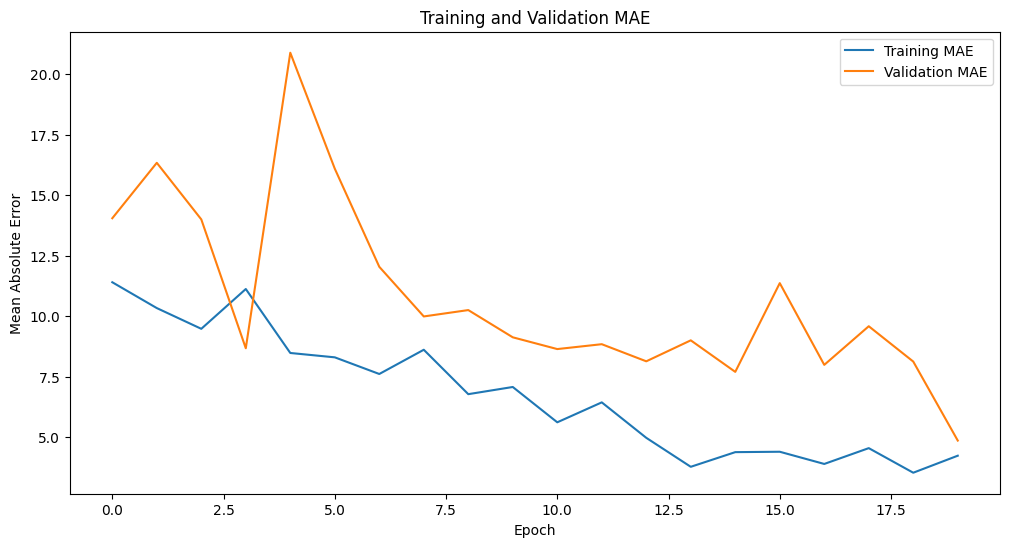

In [ ]:
import matplotlib.pyplot as plt

def train_model(
    model,
    train_gen_flow,
    test_gen_flow,
    epochs=20,
    steps_per_epoch=None,
    validation_steps=None):
    """
    Train the CNN model with the given data.

    Parameters:
    - model: The CNN model to be trained.
    - train_gen_flow: Training data generator.
    - test_gen_flow: Validation data generator.
    - epochs: Number of epochs to train the model.
    - steps_per_epoch: Number of steps per epoch. If None, uses length of train_gen_flow.
    - validation_steps: Number of validation steps. If None, uses length of test_gen_flow.

    Returns:
    - history: The training history object.
    """
    print("Train data generator details:")
    print(f"Batch size: {train_gen_flow.batch_size}")
    print(f"Number of samples: {train_gen_flow.samples}")
    print(f"Image shape: {train_gen_flow.image_shape}")
    print(f"Class mode: {train_gen_flow.class_mode}")

    print("\nTest data generator details:")
    print(f"Batch size: {test_gen_flow.batch_size}")
    print(f"Number of samples: {test_gen_flow.samples}")
    print(f"Image shape: {test_gen_flow.image_shape}")
    print(f"Class mode: {test_gen_flow.class_mode}")

    try:
        train_images, train_labels = next(train_gen_flow)
        print("\nSample train images shape:", train_images.shape)
        print("Sample train labels shape:", train_labels.shape)
    except Exception as e:
        print(f"Error fetching train data: {e}")
        return None

    try:
        test_images, test_labels = next(test_gen_flow)
        print("\nSample test images shape:", test_images.shape)
        print("Sample test labels shape:", test_labels.shape)
    except Exception as e:
        print(f"Error fetching test data: {e}")
        return None

    if steps_per_epoch is None:
        steps_per_epoch = train_gen_flow.samples // train_gen_flow.batch_size
    if validation_steps is None:
        validation_steps = test_gen_flow.samples // test_gen_flow.batch_size

    print(f"Starting training with {steps_per_epoch} steps per epoch and {validation_steps} validation steps.")

    try:
        history = model.fit(
            train_gen_flow,
            validation_data=test_gen_flow,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            verbose=2
        )
        print("Training completed successfully.")
        print("Training history:", history.history)
        return history
    except Exception as e:
        print(f"Error during training: {e}")
        return None

# Calculate steps per epoch
steps_per_epoch = train_gen_flow.samples // train_gen_flow.batch_size
validation_steps = test_gen_flow.samples // test_gen_flow.batch_size

# Train the model
history = train_model(model, train_gen_flow, test_gen_flow, epochs=20, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

# Check if history is not None before proceeding
if history is not None:
    # Evaluate on test data
    try:
        test_loss, test_mae = model.evaluate(test_gen_flow, verbose=1)
        print(f'Test MAE: {test_mae}')
    except Exception as e:
        print(f"Error evaluating model: {e}")

    # Plot training history
    if 'mae' in history.history and 'val_mae' in history.history:
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Absolute Error')
        plt.title('Training and Validation MAE')
        plt.legend()
        plt.show()
    else:
        print("MAE metrics not found in training history.")
else:
    print("No training history available. Please check the training process.")


Based on the results above, an MAE score of 4.8661 for the test dataset was achieved with only 20 epochs, meeting the expected model qualification where MAE Score (test) < 8. This means that the model can predict with an error margin of approximately 4.8 years.

# 4. Conclusion

Here are the conclusions obtained:

**1. Data and Labels:**

The dataset consists of 7591 color images (3 channels) with corresponding labels available in the dataframe.

**2. Age Range:**

The age range in the dataset spans from 1 to 100 years. The majority of the data focuses on the age group of 20-40 years.

**3. Dataset Sample Checking:**

The check of the training dataset shows good alignment between the images and the provided labels.

**4. Model Used:**

The model applied is ResNet50. The model configuration includes a batch size of 32, a loss function using mean squared error, and evaluation metrics using mean absolute error.

**5. Model Evaluation:**

In 20 epochs, the model achieved the target mean absolute error (MAE) < 8. Evaluation results show an MAE of approximately 4.2441 on the training data and 4.8661 on the test data.